In [20]:
import numpy as np
import cv2
import glob
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [22]:
def calibrateImages(img, objpoints, imgpoints):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    

In [23]:
def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx) 
    


In [24]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
calib_images=[]
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    calib_images.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #cv2.imshow('Undistorted Image', undistorted)

#gray_calib = cv2.cvtColor(calib_images[0],cv2.COLOR_BGR2GRAY)      
ret, mtx, dist, rvecs, tvecs = calibrateImages(calib_images[0], objpoints, imgpoints)


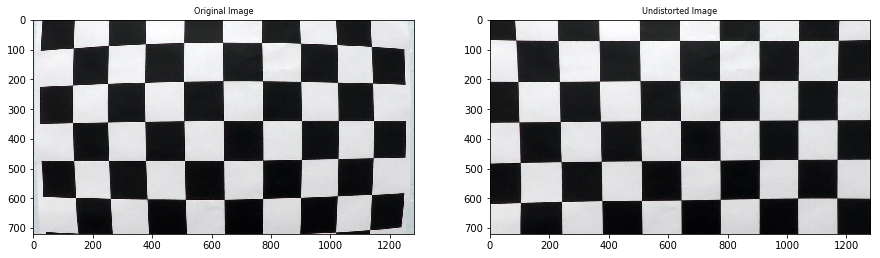

In [25]:
dst = undistortImage(calib_images[0], mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.imshow(calib_images[0])
ax1.set_title('Original Image', fontsize=8)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=8)
        

In [41]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    abs_sobel = None
    if(orient=='x'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    elif(orient=='y'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8((255.0*abs_sobel)/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    #print(np.max(scaled_sobel))
    #print(np.max(abs_sobel))
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])]=1
    
    #print(binary_output)
    # Apply threshold
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    magnitude=np.sqrt(np.square(abs_sobel_x)+np.square(abs_sobel_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_image=np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_image)
    binary_output[(scaled_image>=mag_thresh[0]) & (scaled_image<=mag_thresh[1])]=1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(absgraddir)
    binary_output[(absgraddir>=thresh[0]) & (absgraddir<=thresh[1])]=1
    # Apply threshold
    return binary_output

# Choose a Sobel kernel size


# Apply each of the thresholding functions
# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

255
255


255
255


255
255


255
255


255
255


255
255


255
255


255
255


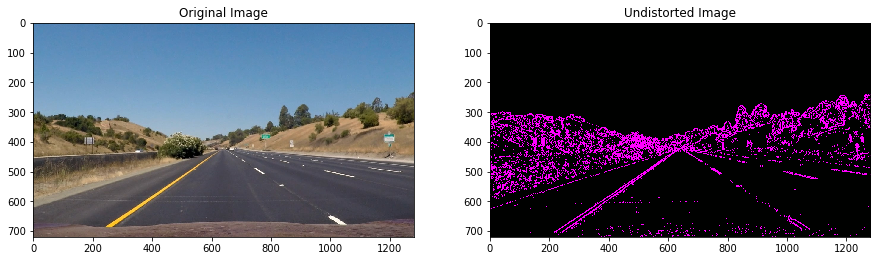

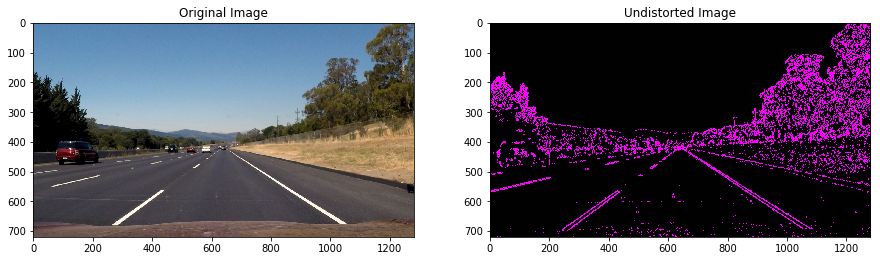

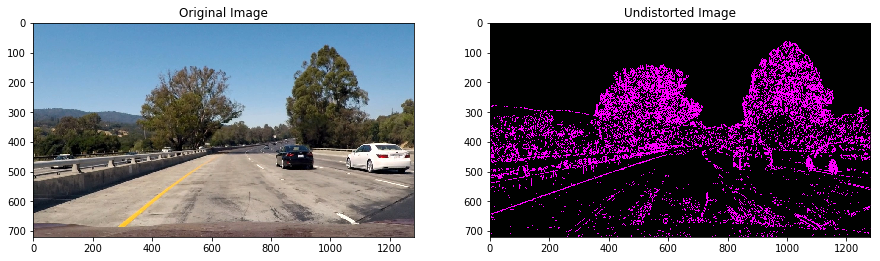

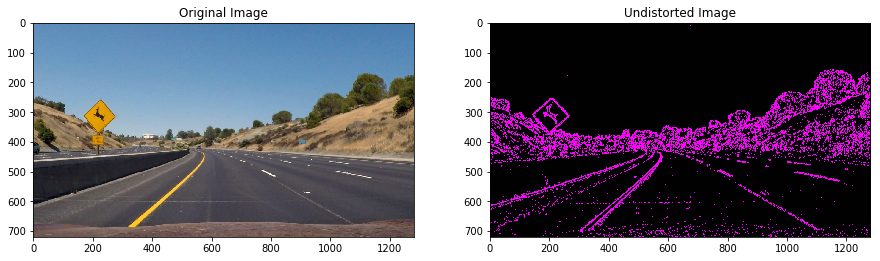

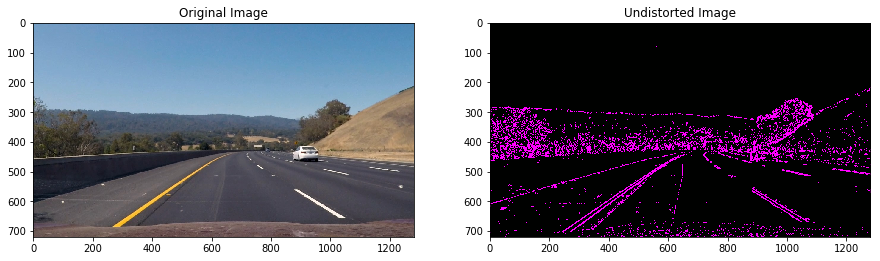

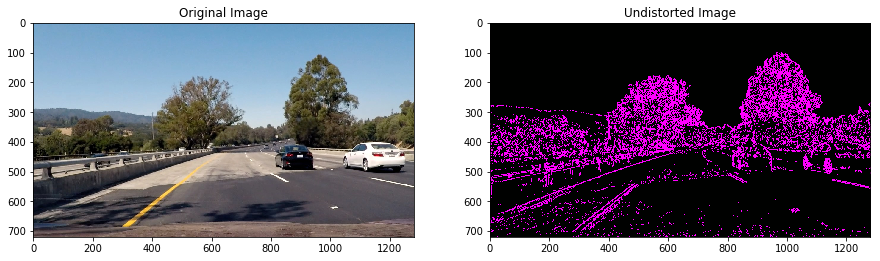

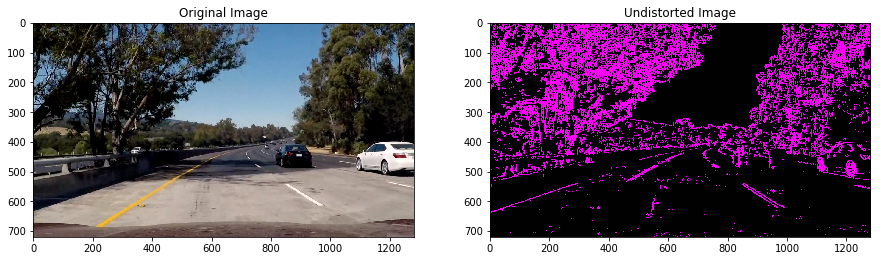

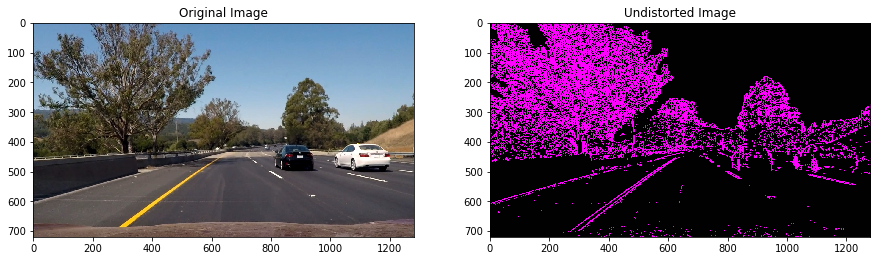

In [50]:
fig=plt.figure(figsize=(8, 8))
columns = 2
undistorted_output_path="./output_images/undistorted_test_images/"
test_images_path="./test_images/"
file_names = listdir(test_images_path)
rows = len(file_names)
for name in file_names:
    test_image = cv2.imread(test_images_path+name)
    BGRtoRGB = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    undistorted=undistortImage(BGRtoRGB, mtx, dist)
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(0, 255))
    mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(0, 255))
    dir_binary = dir_threshold(undistorted, sobel_kernel=3, thresh=(0, np.pi/2))
    # combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plotting undistorted images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    ax1.imshow(BGRtoRGB)
    ax1.set_title('Original Image', fontsize=12)
    gradx=np.uint8(gradx*255)
    # print(np.max(gradx))
    ax2.imshow(np.dstack((gradx,mag_binary,gradx)))
    ax2.set_title('Undistorted Image', fontsize=12)
    #cv2.imwrite(undistorted_output_path+name,undistorted)
    #mpimg.imsave(undistorted_output_path+name,undistorted)
    